In [4]:
# set workspace
WhoIsWorking = "AI"
WorkLocation = "School"

if WhoIsWorking == "RT":
    if WorkLocation == "Home":
        folder_path = r'C:\Users\rentr\Desktop\ENGO\DataMining\ENGO645_TermProject_Data'
    elif WorkLocation == "School":
        folder_path = r'D:\ENGO645_TermProject_Data'
elif WhoIsWorking == "AA":
    folder_path = ''
elif WhoIsWorking == "IA":
    folder_path = r'C:\Users\afoam\assignments\ENGO645_TorontoCrimeAnalysis'
elif WhoIsWorking == "AI":
    folder_path = r'C:\Adewale_Directory\Capacity_Building\MGIS\Lecture_Note\WINTER2024\ENGO645\Course_Project\Project_Data'

print(folder_path)

C:\Adewale_Directory\Capacity_Building\MGIS\Lecture_Note\WINTER2024\ENGO645\Course_Project\Project_Data


In [ ]:
# pip install pysal

In [5]:
#Install and import neccessary libraries
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import libpysal
from esda.moran import Moran
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load and read the MCI file
MCI_file = os.path.join(folder_path, "MCI_Cleaned.csv") # Update to the actual file location
MCI_data = pd.read_csv(MCI_file)
 
MCI_data #display dataframe

,OCC_YEAR,OCC_MONTH,SEASON,OCC_DAY,OCC_DOY,OCC_DOW,DOW_WorkvsEnd,OCC_HOUR,TIMECategory,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY,NEIGHBOURHOOD_158,LONG_WGS84,LAT_WGS84,DATE_TIME_LINK,TEMP,TEMPCategory
0,2023,January,Winter,1,1,Sunday,Weekend,2,Night,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery With Weapon,Robbery,Corso Italia-Davenport,-79.450529,43.676205,2023/1/1 2,4.7,Mild
1,2023,January,Winter,1,1,Sunday,Weekend,1,Night,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Robbery - Other,Robbery,St Lawrence-East Bayfront-The Islands,-79.368457,43.648776,2023/1/1 1,4.5,Mild
2,2023,January,Winter,1,1,Sunday,Weekend,9,Morning,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,Morningside Heights,-79.202638,43.815274,2023/1/1 9,4.4,Mild
3,2023,January,Winter,1,1,Sunday,Weekend,3,Night,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault With Weapon,Assault,New Toronto,-79.517052,43.600915,2023/1/1 3,4.9,Mild
4,2023,January,Winter,1,1,Sunday,Weekend,21,Evening,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Theft Of Motor Vehicle,Auto Theft,Victoria Village,-79.300571,43.719703,2023/1/1 21,4.1,Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365681,2014,December,Winter,31,365,Wednesday,Weekday,16,Afternoon,"Apartment (Rooming House, Condo)",Apartment,B&E,Break and Enter,Wellington Place,-79.390275,43.647849,2014/12/31 16,-6.3,Chilly
365682,2014,December,Winter,31,365,Wednesday,Weekday,12,Afternoon,"Single Home, House (Attach Garage, Cottage, Mo...",House,Assault With Weapon,Assault,Bendale-Glen Andrew,-79.248690,43.761776,2014/12/31 12,-6.3,Chilly
365683,2014,December,Winter,31,365,Wednesday,Weekday,12,Afternoon,"Single Home, House (Attach Garage, Cottage, Mo...",House,Assault,Assault,Bendale-Glen Andrew,-79.248690,43.761776,2014/12/31 12,-6.3,Chilly
365684,2014,December,Winter,31,365,Wednesday,Weekday,22,Evening,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,Greenwood-Coxwell,-79.325929,43.671381,2014/12/31 22,-5.7,Chilly


In [7]:
# Find the count of offenses by neighborhood to aggregate data to Neighbourhood level
neighbourhood_counts = MCI_data['NEIGHBOURHOOD_158'].value_counts().reset_index()
neighbourhood_counts.columns = ['NeighbourhoodName', 'Crime_Count']  # Rename columns

neighbourhood_counts

,NeighbourhoodName,Crime_Count
0,West Humber-Clairville,10309
1,Moss Park,8621
2,Downtown Yonge East,7762
3,Yonge-Bay Corridor,7294
4,York University Heights,7237
...,...,...
154,Maple Leaf,734
155,Guildwood,680
156,Woodbine-Lumsden,649
157,Lambton Baby Point,585


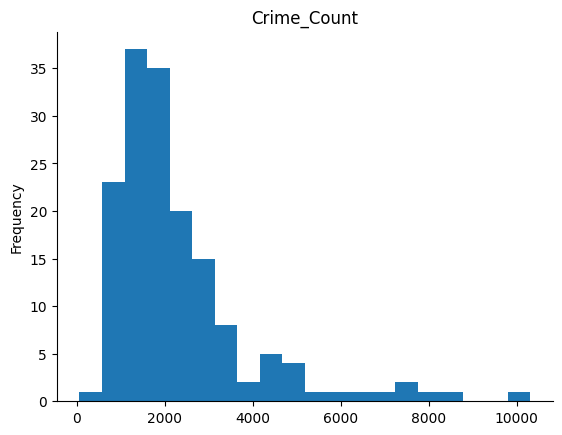

In [8]:
# Plot the Crime Count Histogram
neighbourhood_counts['Crime_Count'].plot(kind='hist', bins=20, title='Crime_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
# Check normality test using Shapiro-Wilk
from scipy.stats import shapiro

# Perform Shapiro-Wilk test
stat, p_value = shapiro(neighbourhood_counts['Crime_Count'])

# Print the results
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

Shapiro-Wilk Test Statistic: 0.7833097577095032
p-value: 4.575359256503604e-14


In [10]:
# Load and read the Normalized Neighbourhood file
neighbourhood_file = os.path.join(folder_path, "Neighbourhood_Cleaned_Normalized.csv")
neighbourhood_data = pd.read_csv(neighbourhood_file)

In [11]:
# Check Neighbourhood File for 'geometry' column
if 'geometry' in neighbourhood_data.columns:
    neighbourhood_data.drop(columns=['geometry'], inplace=True)
else:
    print("Column 'geometry' not found in the DataFrame.")

neighbourhood_data

Column 'geometry' not found in the DataFrame.


,Unnamed: 0,NeighbourhoodName,Poles_Count,POI_Count,TCamera_Count,TotalPopulation,MedianTotalIncome,AverageTotalIncome,BuildingCoveragePERCENTAGE,ParksOSNAPERCENTAGE,BuiltUpPERCENTAGE,AveragePrice,MedianTotalIncome_normalized,AverageTotalIncome_normalized,AverageHousePrice_normalized
0,0,South Eglinton-Davisville,649,1185,2,22735,52400,69000,29.087555,6.375824,93.624176,1035636,0.520607,0.173043,0.093478
1,1,North Toronto,286,851,2,15885,46000,58100,31.403497,1.133288,98.866712,1035636,0.381779,0.119580,0.093478
2,2,Dovercourt Village,1170,534,1,12380,38000,55850,33.231409,7.875048,92.124952,1266076,0.208243,0.108544,0.189245
3,3,Junction-Wallace Emerson,1663,876,1,23180,41200,54350,33.167140,6.821523,93.178477,1266076,0.277657,0.101187,0.189245
4,4,Yonge-Bay Corridor,1139,20281,12,12645,44000,68200,48.028587,6.382056,93.617944,880955,0.338395,0.169119,0.029196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,153,West Humber-Clairville,7704,4254,2,33300,33600,40560,17.465098,11.373365,88.626635,811543,0.112798,0.033549,0.000349
154,154,Black Creek,1148,541,1,21145,29400,33720,17.667624,15.911150,84.088850,836734,0.021692,0.000000,0.010818
155,155,Pelmo Park-Humberlea,1223,369,1,11290,39600,49000,14.734703,17.357255,82.642745,836734,0.242950,0.074946,0.010818
156,156,Humbermede,1031,707,1,16955,32400,38280,17.920562,21.469614,78.530386,836734,0.086768,0.022366,0.010818


In [12]:
# Load the Neighbourhood shapefile
NeighbourhoodBoundary_SHP = os.path.join(folder_path, "Neighbourhoods.shp")
neighbourhood_SHP = gpd.read_file(NeighbourhoodBoundary_SHP)

# Drop all fields except geometry and name fields from neighbourhood_SHP
neighbourhood_SHP = neighbourhood_SHP[['geometry', 'AREA_NA7']]

neighbourhood_SHP

,geometry,AREA_NA7
0,"POLYGON ((-79.38635 43.69783, -79.38623 43.697...",South Eglinton-Davisville
1,"POLYGON ((-79.39744 43.70693, -79.39837 43.706...",North Toronto
2,"POLYGON ((-79.43411 43.66015, -79.43537 43.659...",Dovercourt Village
3,"POLYGON ((-79.43870 43.66766, -79.43841 43.666...",Junction-Wallace Emerson
4,"POLYGON ((-79.38404 43.64497, -79.38502 43.644...",Yonge-Bay Corridor
...,...,...
153,"POLYGON ((-79.59037 43.73401, -79.58942 43.732...",West Humber-Clairville
154,"POLYGON ((-79.51915 43.77399, -79.51901 43.773...",Black Creek
155,"POLYGON ((-79.53225 43.73505, -79.52938 43.723...",Pelmo Park-Humberlea
156,"POLYGON ((-79.52813 43.74425, -79.52721 43.740...",Humbermede


In [13]:
# Join the neighbourhood dataframe with the Neighbourhood geodataframe using 'NeighbourhoodName' and 'AREA_NA7' respectively
joined_data = neighbourhood_SHP.merge(neighbourhood_data, left_on='AREA_NA7', right_on='NeighbourhoodName', how='right')

joined_data

,geometry,AREA_NA7,Unnamed: 0,NeighbourhoodName,Poles_Count,POI_Count,TCamera_Count,TotalPopulation,MedianTotalIncome,AverageTotalIncome,BuildingCoveragePERCENTAGE,ParksOSNAPERCENTAGE,BuiltUpPERCENTAGE,AveragePrice,MedianTotalIncome_normalized,AverageTotalIncome_normalized,AverageHousePrice_normalized
0,"POLYGON ((-79.38635 43.69783, -79.38623 43.697...",South Eglinton-Davisville,0,South Eglinton-Davisville,649,1185,2,22735,52400,69000,29.087555,6.375824,93.624176,1035636,0.520607,0.173043,0.093478
1,"POLYGON ((-79.39744 43.70693, -79.39837 43.706...",North Toronto,1,North Toronto,286,851,2,15885,46000,58100,31.403497,1.133288,98.866712,1035636,0.381779,0.119580,0.093478
2,"POLYGON ((-79.43411 43.66015, -79.43537 43.659...",Dovercourt Village,2,Dovercourt Village,1170,534,1,12380,38000,55850,33.231409,7.875048,92.124952,1266076,0.208243,0.108544,0.189245
3,"POLYGON ((-79.43870 43.66766, -79.43841 43.666...",Junction-Wallace Emerson,3,Junction-Wallace Emerson,1663,876,1,23180,41200,54350,33.167140,6.821523,93.178477,1266076,0.277657,0.101187,0.189245
4,"POLYGON ((-79.38404 43.64497, -79.38502 43.644...",Yonge-Bay Corridor,4,Yonge-Bay Corridor,1139,20281,12,12645,44000,68200,48.028587,6.382056,93.617944,880955,0.338395,0.169119,0.029196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,"POLYGON ((-79.59037 43.73401, -79.58942 43.732...",West Humber-Clairville,153,West Humber-Clairville,7704,4254,2,33300,33600,40560,17.465098,11.373365,88.626635,811543,0.112798,0.033549,0.000349
154,"POLYGON ((-79.51915 43.77399, -79.51901 43.773...",Black Creek,154,Black Creek,1148,541,1,21145,29400,33720,17.667624,15.911150,84.088850,836734,0.021692,0.000000,0.010818
155,"POLYGON ((-79.53225 43.73505, -79.52938 43.723...",Pelmo Park-Humberlea,155,Pelmo Park-Humberlea,1223,369,1,11290,39600,49000,14.734703,17.357255,82.642745,836734,0.242950,0.074946,0.010818
156,"POLYGON ((-79.52813 43.74425, -79.52721 43.740...",Humbermede,156,Humbermede,1031,707,1,16955,32400,38280,17.920562,21.469614,78.530386,836734,0.086768,0.022366,0.010818


In [14]:
# Join the aggregated crime counts with neighborhood joined_data based on the common neighborhood field (NeighbourhoodName)
neighbourhood_merged = joined_data.merge(neighbourhood_counts, on='NeighbourhoodName', how='left')

# Drop rows with missing values (if any)
neighbourhood_merged = neighbourhood_merged.dropna(subset=['Crime_Count'])

In [15]:
# Check if all geometries are valid
all_valid = neighbourhood_merged.geometry.is_valid.all()

if all_valid:
    print("All geometries are valid.")
else:
    print("Some geometries are invalid.")

All geometries are valid.


In [16]:
# Convert neighbourhood_merged to a geodataframe
neighbourhood_gdf = gpd.GeoDataFrame(neighbourhood_merged, geometry='geometry')

neighbourhood_gdf.info() # Check geo dataframe data type

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   geometry                       158 non-null    geometry
 1   AREA_NA7                       158 non-null    object  
 2   Unnamed: 0                     158 non-null    int64   
 3   NeighbourhoodName              158 non-null    object  
 4   Poles_Count                    158 non-null    int64   
 5   POI_Count                      158 non-null    int64   
 6   TCamera_Count                  158 non-null    int64   
 7   TotalPopulation                158 non-null    int64   
 8   MedianTotalIncome              158 non-null    int64   
 9   AverageTotalIncome             158 non-null    int64   
 10  BuildingCoveragePERCENTAGE     158 non-null    float64 
 11  ParksOSNAPERCENTAGE            158 non-null    float64 
 12  BuiltUpPERCENTAGE           

In [17]:
# Select relevant features for further analysis
neighbourhood_gdf = neighbourhood_gdf[['NeighbourhoodName', 'Crime_Count', 'Poles_Count', 'POI_Count', 'TCamera_Count', 'TotalPopulation', 'MedianTotalIncome_normalized',
                                      'AverageTotalIncome_normalized','AverageHousePrice_normalized', 'BuildingCoveragePERCENTAGE', 
                                      'ParksOSNAPERCENTAGE', 'BuiltUpPERCENTAGE', 'geometry']]

neighbourhood_gdf

,NeighbourhoodName,Crime_Count,Poles_Count,POI_Count,TCamera_Count,TotalPopulation,MedianTotalIncome_normalized,AverageTotalIncome_normalized,AverageHousePrice_normalized,BuildingCoveragePERCENTAGE,ParksOSNAPERCENTAGE,BuiltUpPERCENTAGE,geometry
0,South Eglinton-Davisville,1539,649,1185,2,22735,0.520607,0.173043,0.093478,29.087555,6.375824,93.624176,"POLYGON ((-79.38635 43.69783, -79.38623 43.697..."
1,North Toronto,1334,286,851,2,15885,0.381779,0.119580,0.093478,31.403497,1.133288,98.866712,"POLYGON ((-79.39744 43.70693, -79.39837 43.706..."
2,Dovercourt Village,1652,1170,534,1,12380,0.208243,0.108544,0.189245,33.231409,7.875048,92.124952,"POLYGON ((-79.43411 43.66015, -79.43537 43.659..."
3,Junction-Wallace Emerson,2944,1663,876,1,23180,0.277657,0.101187,0.189245,33.167140,6.821523,93.178477,"POLYGON ((-79.43870 43.66766, -79.43841 43.666..."
4,Yonge-Bay Corridor,7294,1139,20281,12,12645,0.338395,0.169119,0.029196,48.028587,6.382056,93.617944,"POLYGON ((-79.38404 43.64497, -79.38502 43.644..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,West Humber-Clairville,10309,7704,4254,2,33300,0.112798,0.033549,0.000349,17.465098,11.373365,88.626635,"POLYGON ((-79.59037 43.73401, -79.58942 43.732..."
154,Black Creek,3527,1148,541,1,21145,0.021692,0.000000,0.010818,17.667624,15.911150,84.088850,"POLYGON ((-79.51915 43.77399, -79.51901 43.773..."
155,Pelmo Park-Humberlea,1682,1223,369,1,11290,0.242950,0.074946,0.010818,14.734703,17.357255,82.642745,"POLYGON ((-79.53225 43.73505, -79.52938 43.723..."
156,Humbermede,2669,1031,707,1,16955,0.086768,0.022366,0.010818,17.920562,21.469614,78.530386,"POLYGON ((-79.52813 43.74425, -79.52721 43.740..."


In [18]:
# Create a spatial weights matrix using queen contiguity
W = libpysal.weights.Queen.from_dataframe(neighbourhood_gdf)

# Perform Global Moran's I analysis
moran = Moran(neighbourhood_gdf['Crime_Count'], W)

# Print the Moran's I statistic and p-value
print('Moran\'s I:', moran.I)
print('p-value:', moran.p_sim)

Moran's I: 0.23774395116978736
p-value: 0.001
